#### Goal:
-> Establish simple baseline models for anomaly detection and evaluate their effectiveness. This gives you a reference point for more advanced methods later.

- Baseline anomaly detection with moving average and z-score methods.
- Visualization of detected vs ground truth anomalies.
- Precision, recall, and F1-score computation for both methods.
- A summary table for all metrics.

Loaded metrics: ['ec2_cpu_utilization_825cc2', 'iio_us-east-1_i-a2eb1cd9_NetworkIn', 'ec2_cpu_utilization_53ea38', 'ec2_cpu_utilization_fe7f93', 'rds_cpu_utilization_cc0c53', 'ec2_cpu_utilization_c6585a', 'grok_asg_anomaly', 'ec2_cpu_utilization_5f5533', 'ec2_disk_write_bytes_1ef3de', 'ec2_cpu_utilization_24ae8d', 'ec2_network_in_257a54', 'ec2_cpu_utilization_ac20cd', 'elb_request_count_8c0756', 'rds_cpu_utilization_e47b3b', 'ec2_cpu_utilization_77c1ca', 'ec2_disk_write_bytes_c0d644', 'ec2_network_in_5abac7']


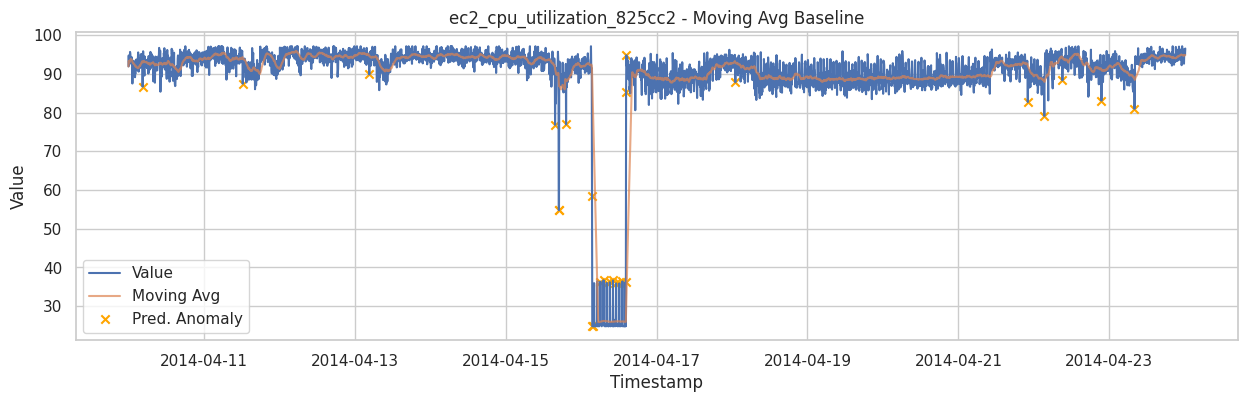

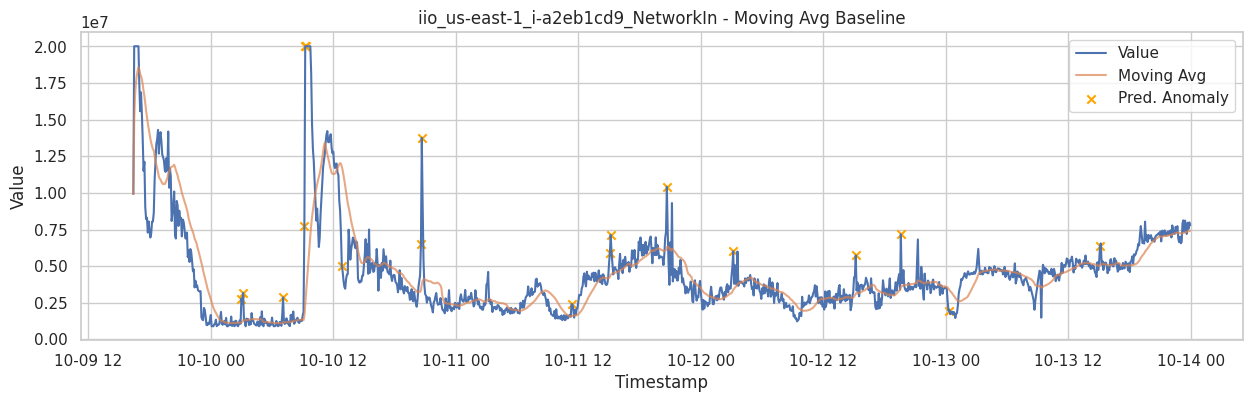

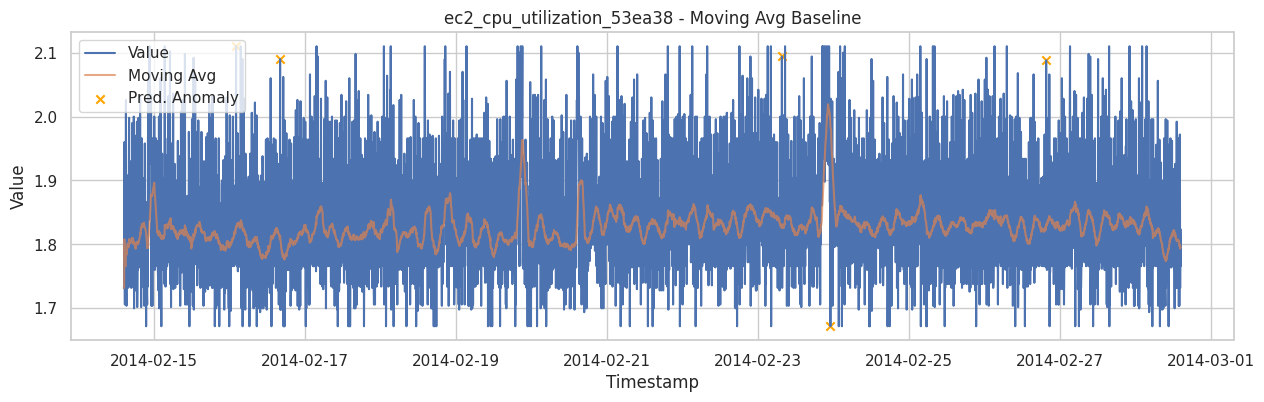

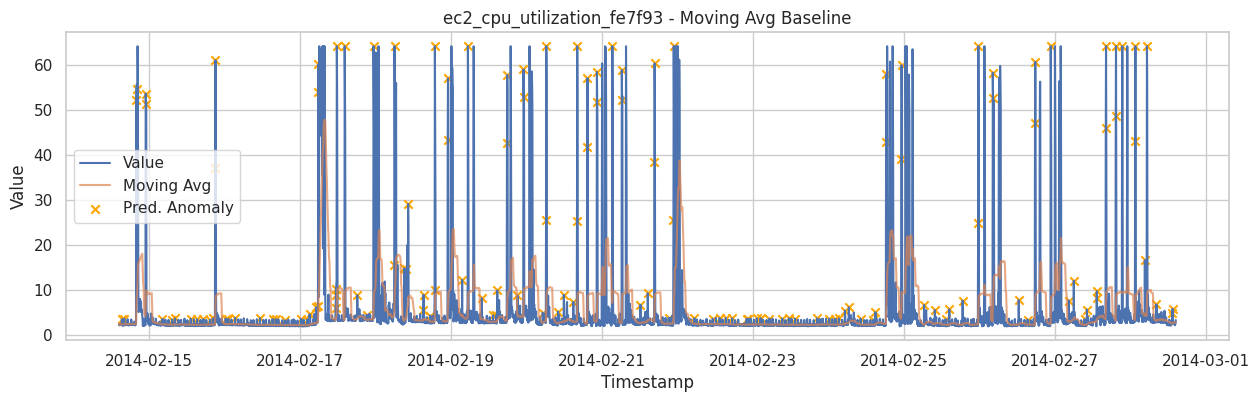

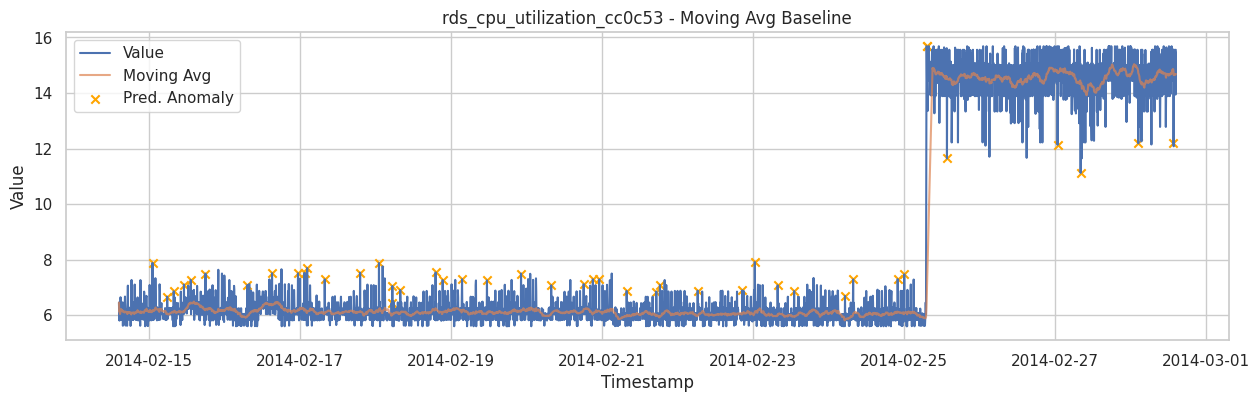

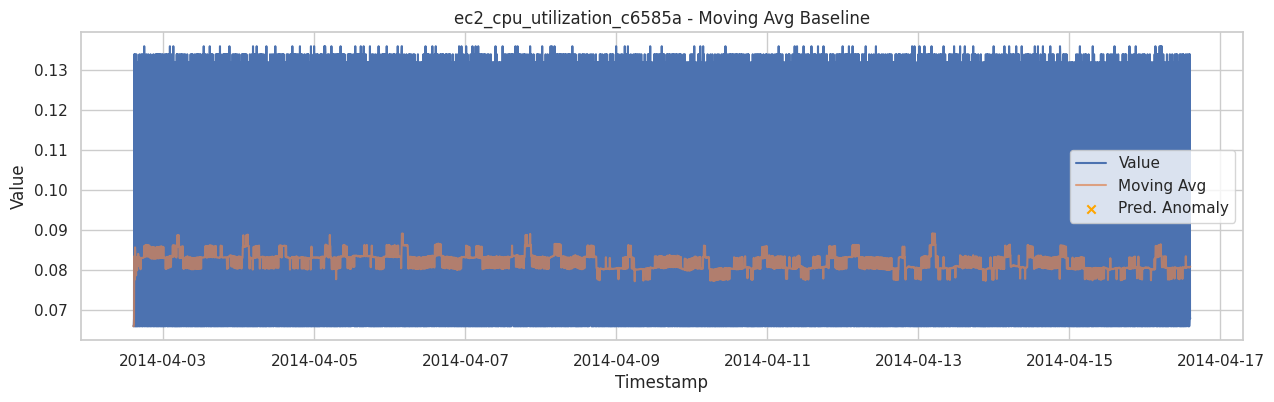

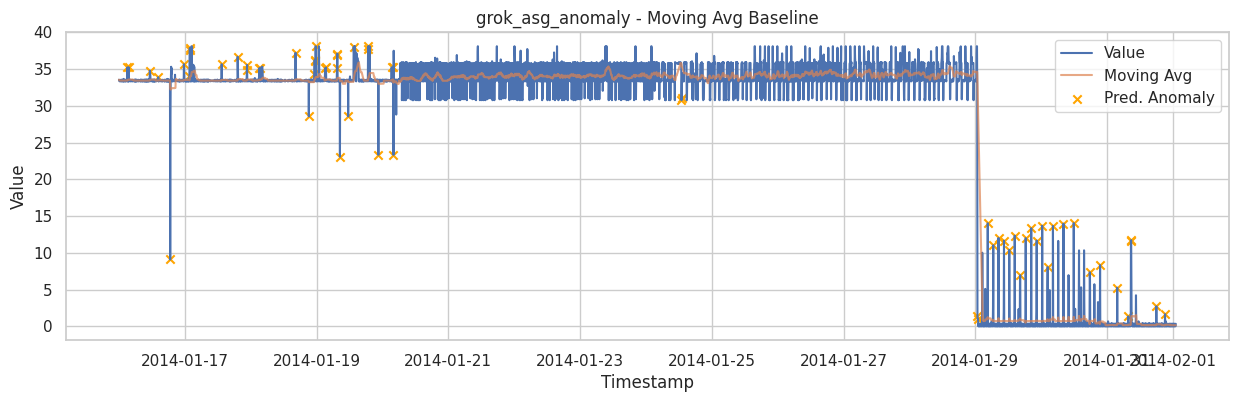

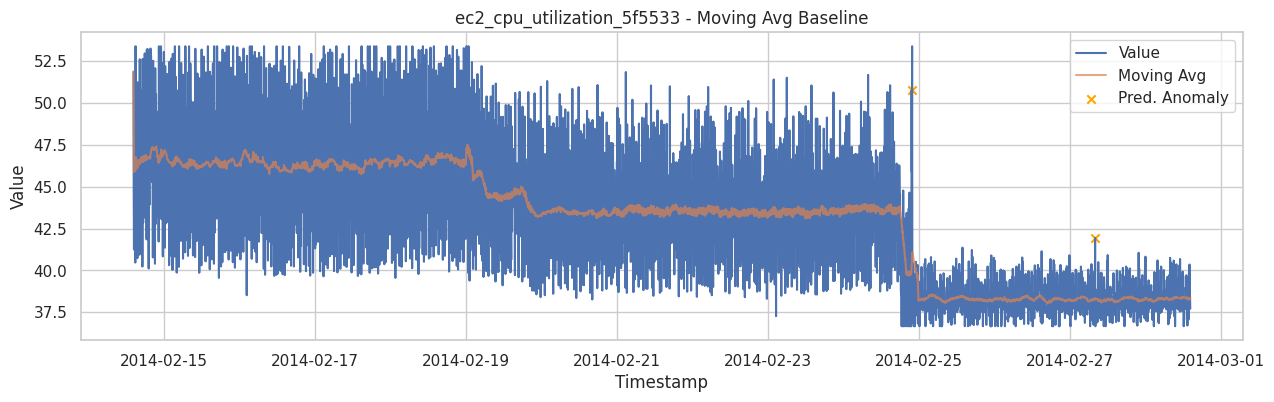

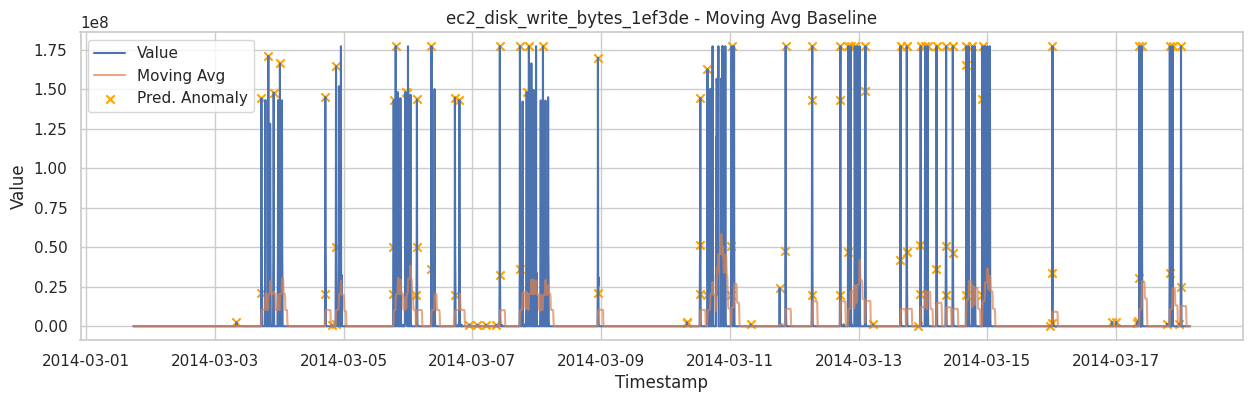

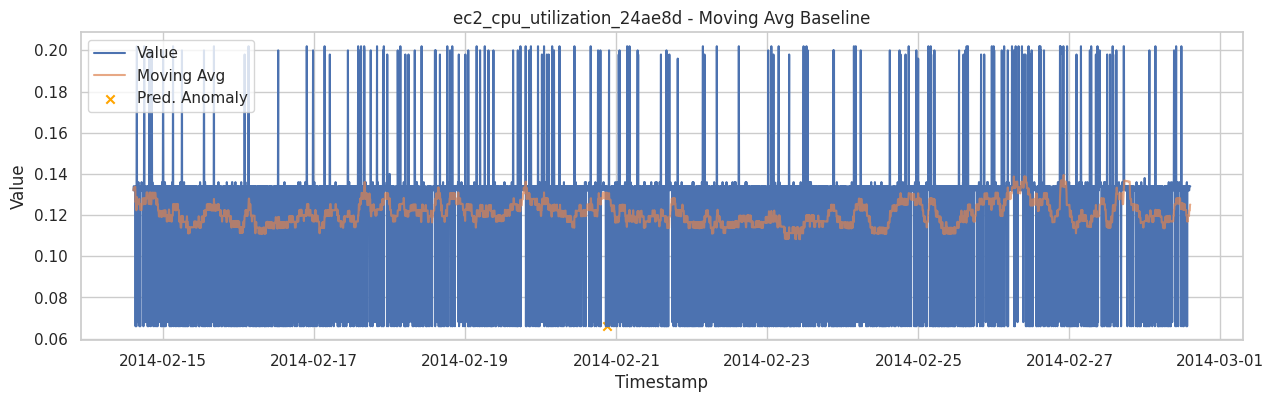

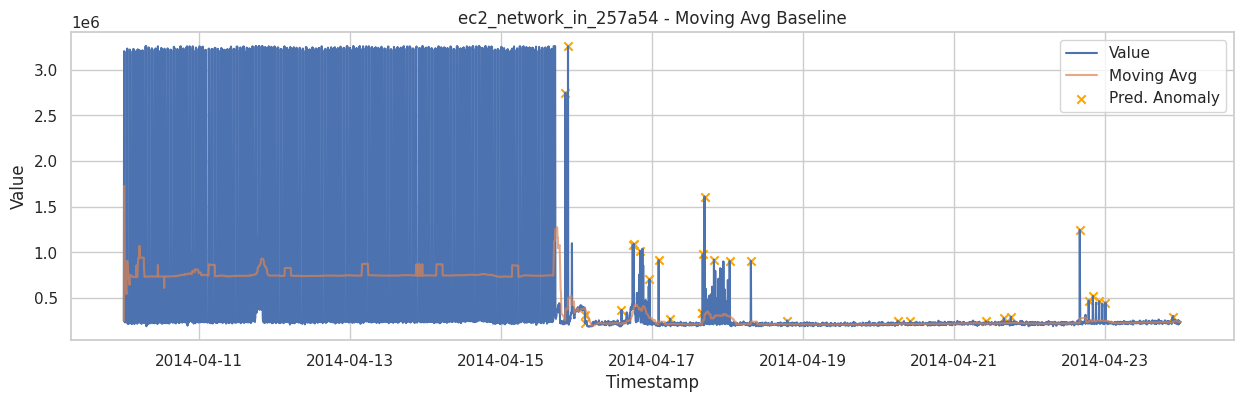

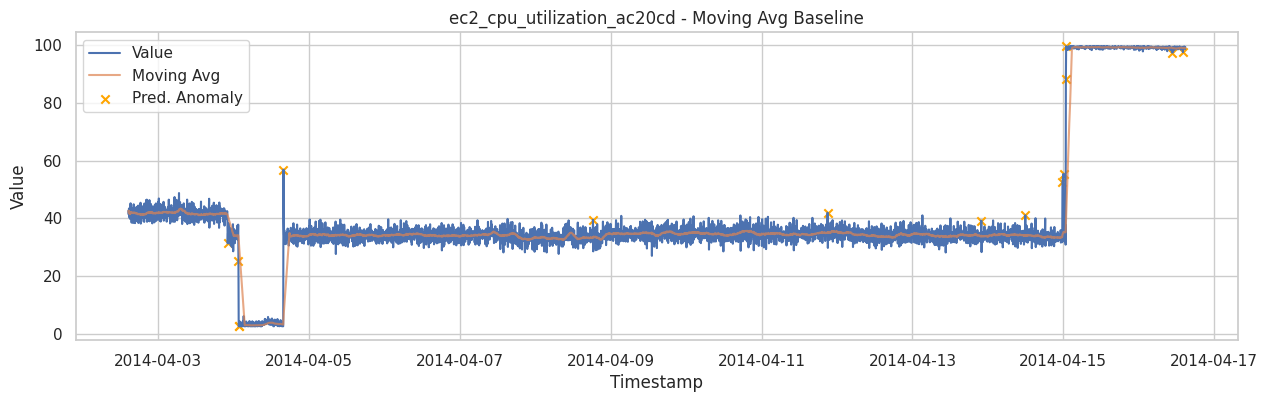

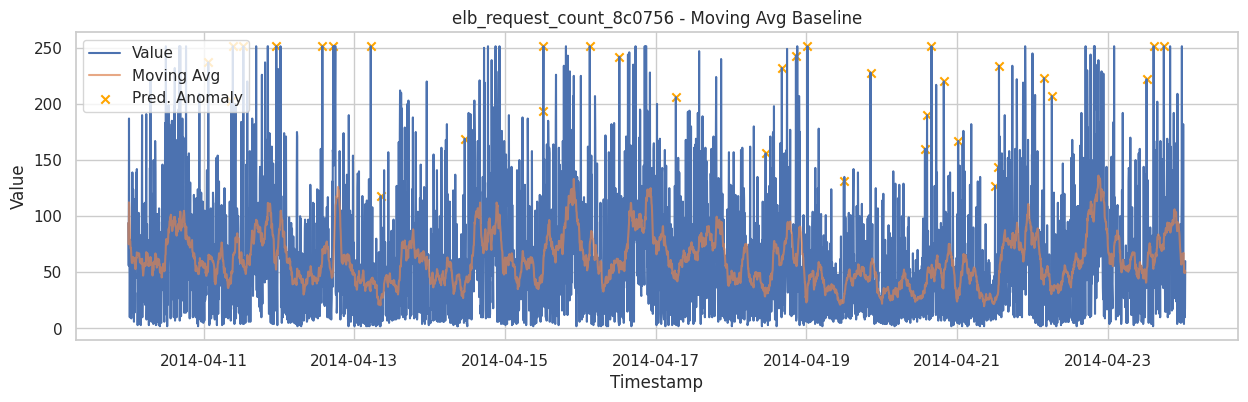

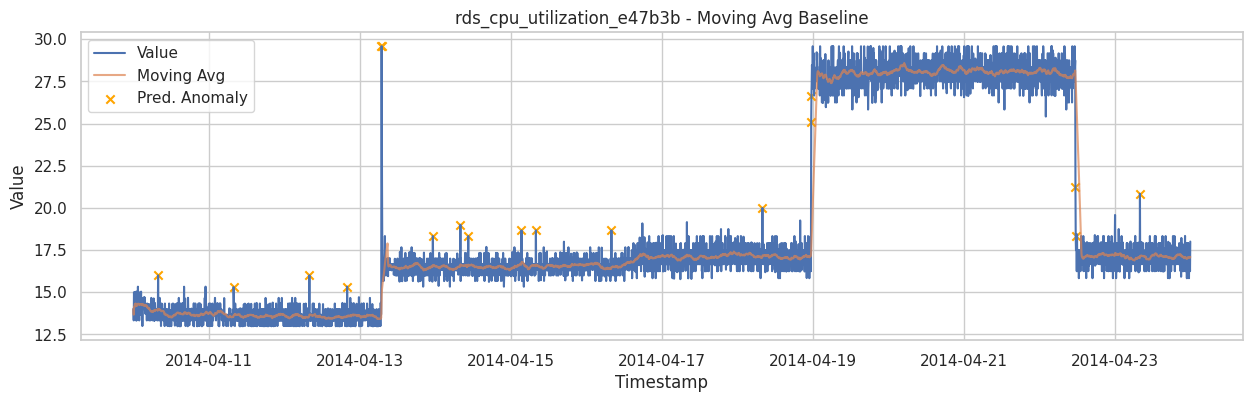

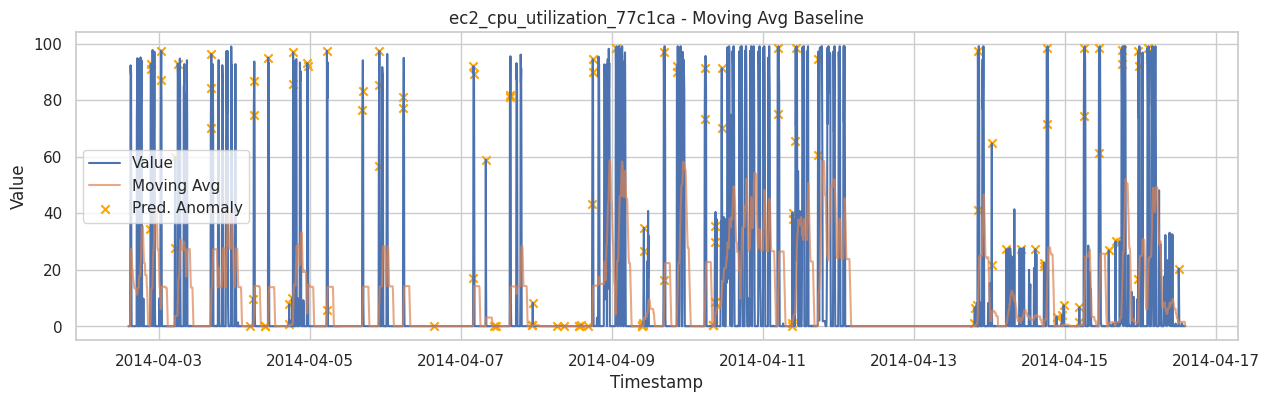

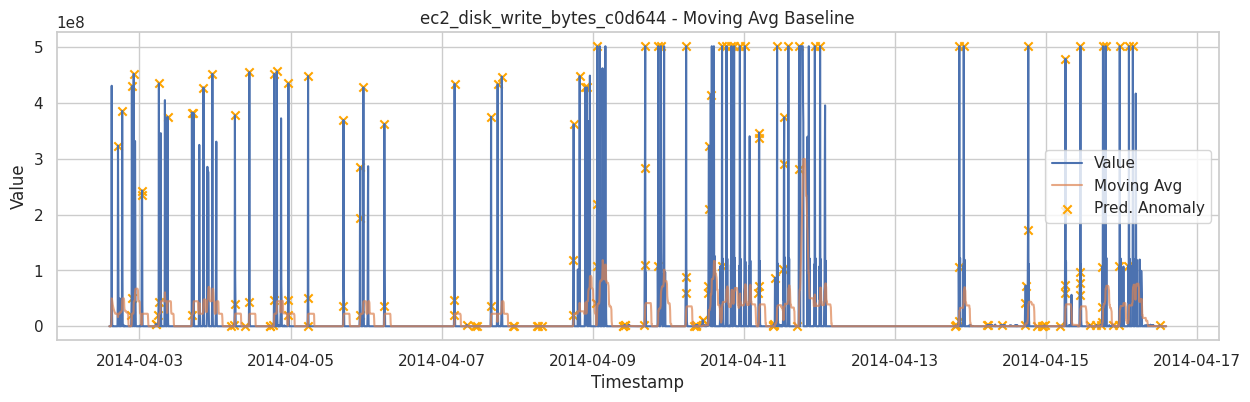

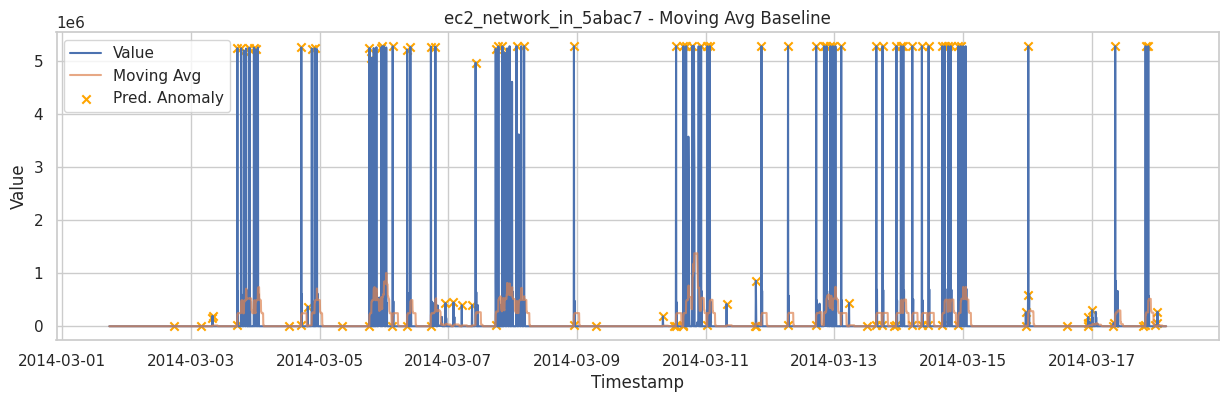

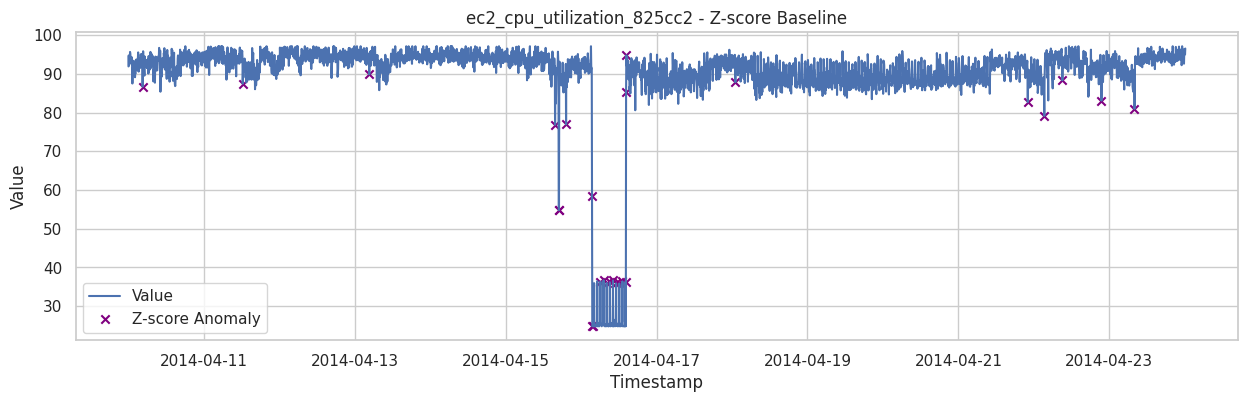

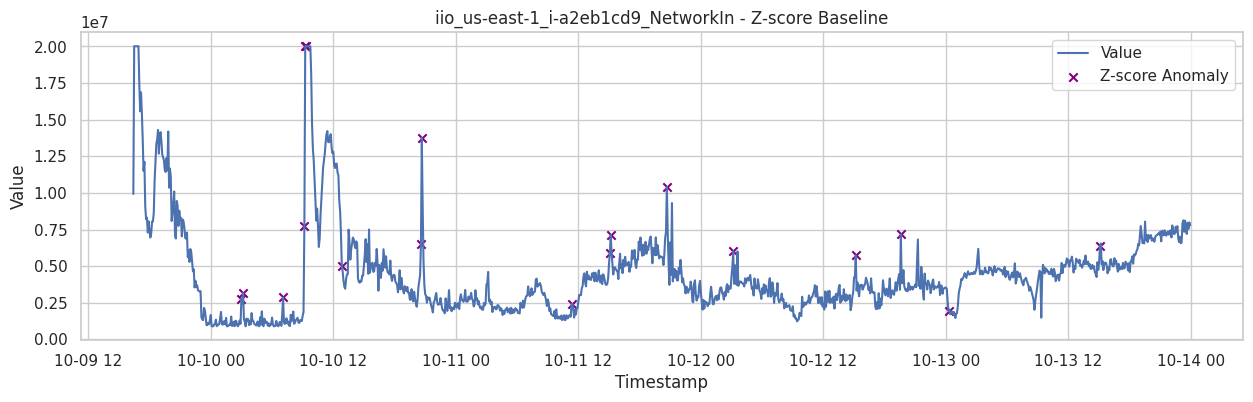

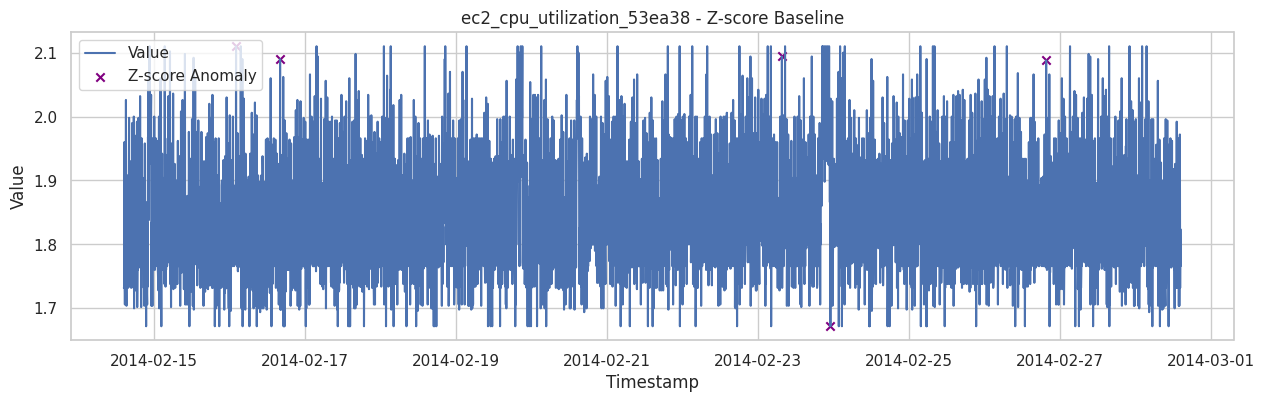

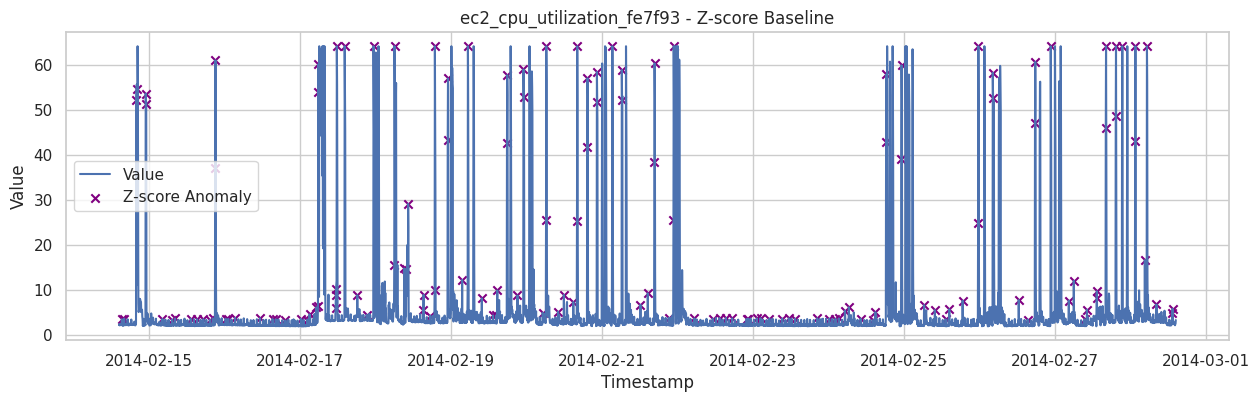

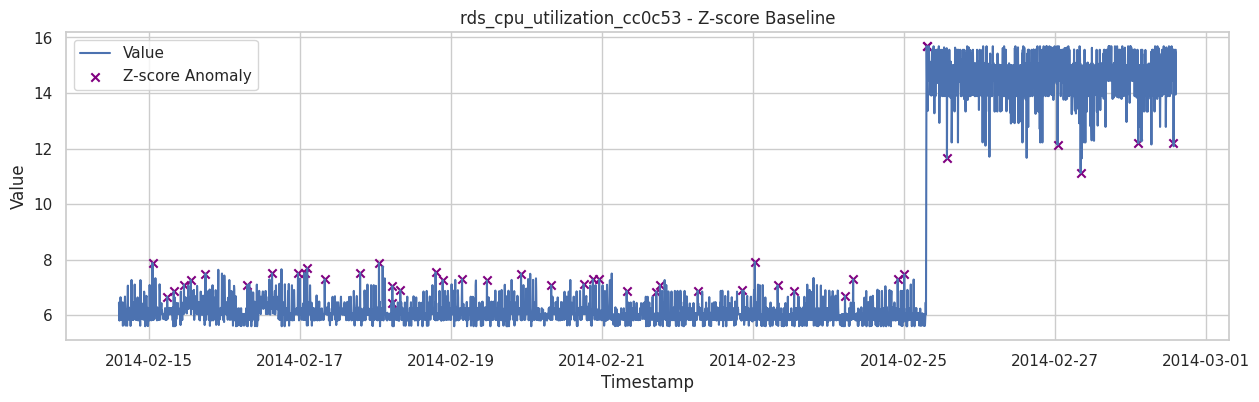

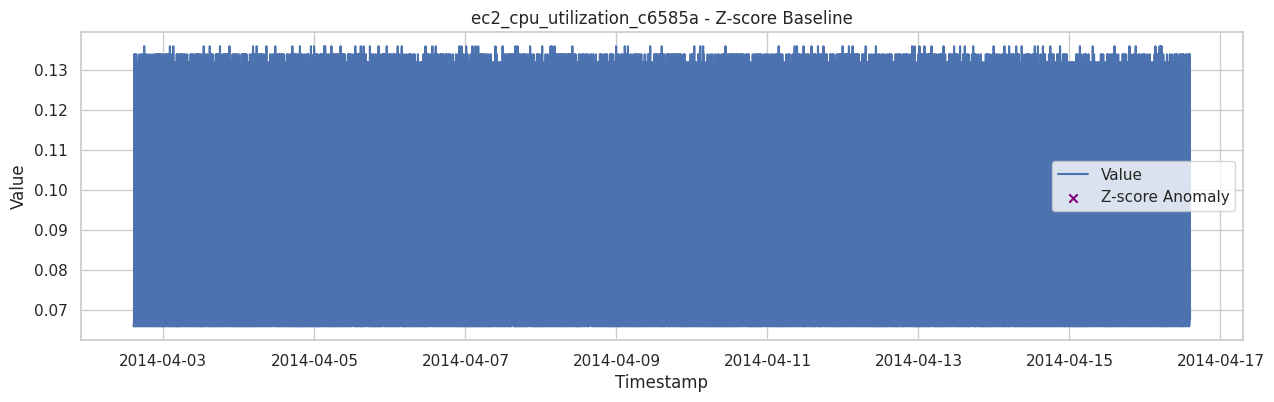

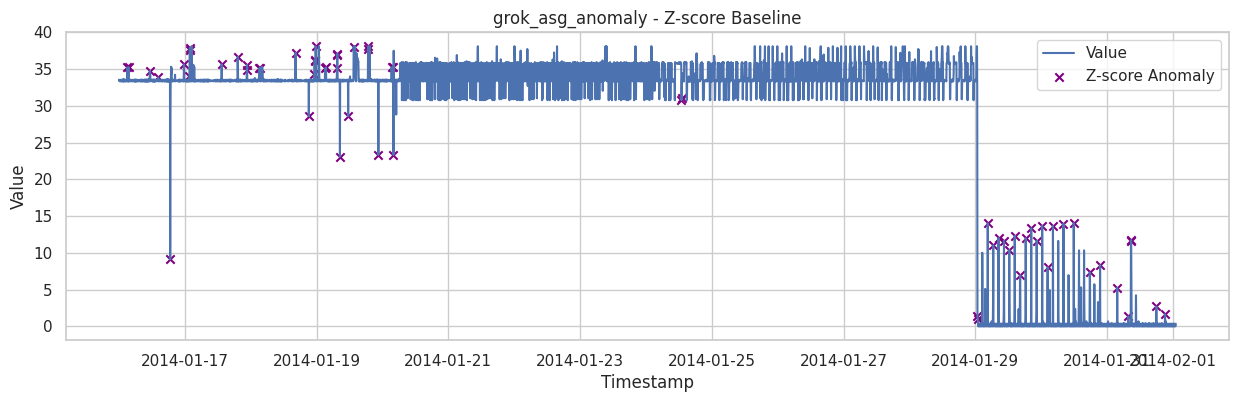

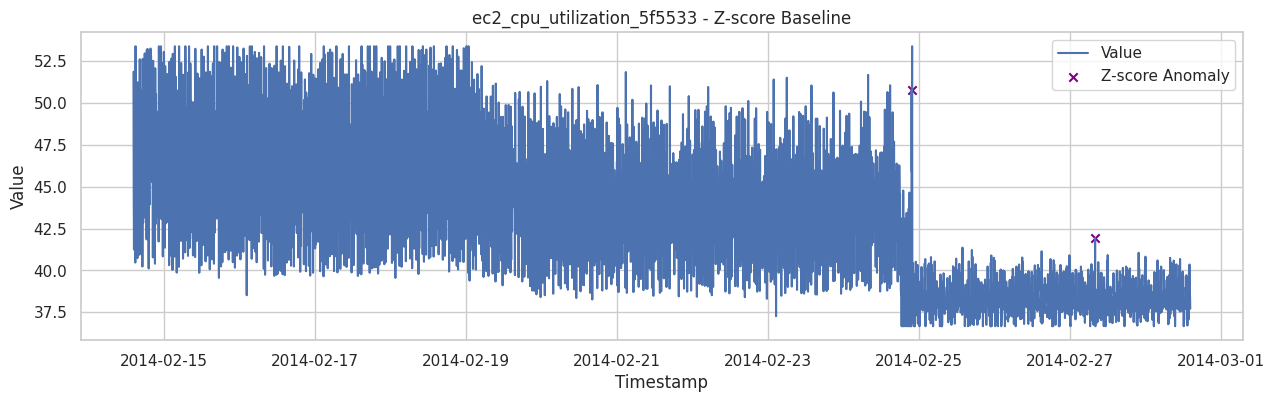

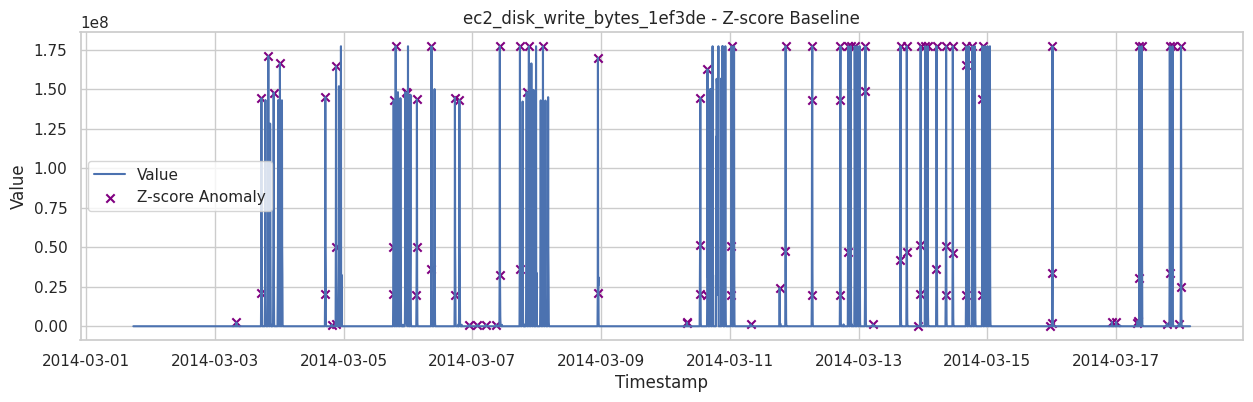

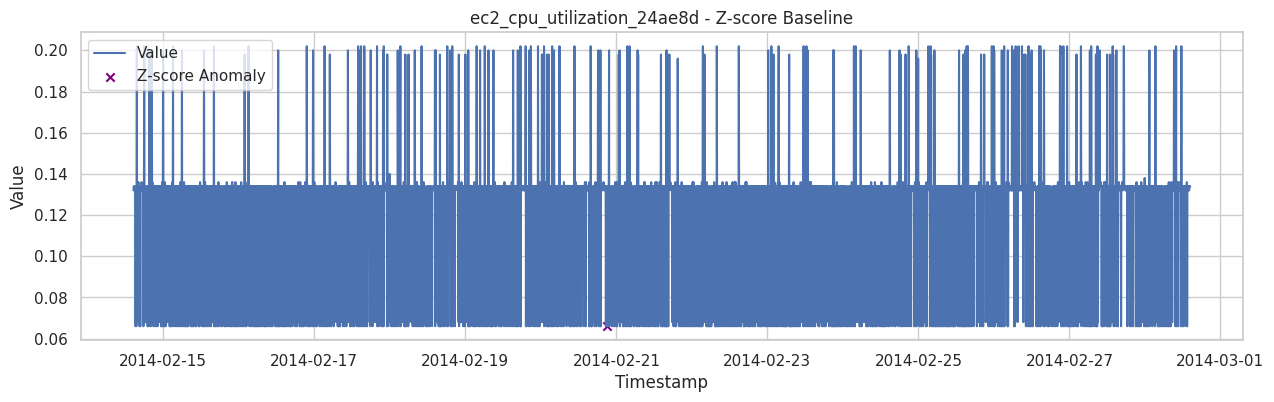

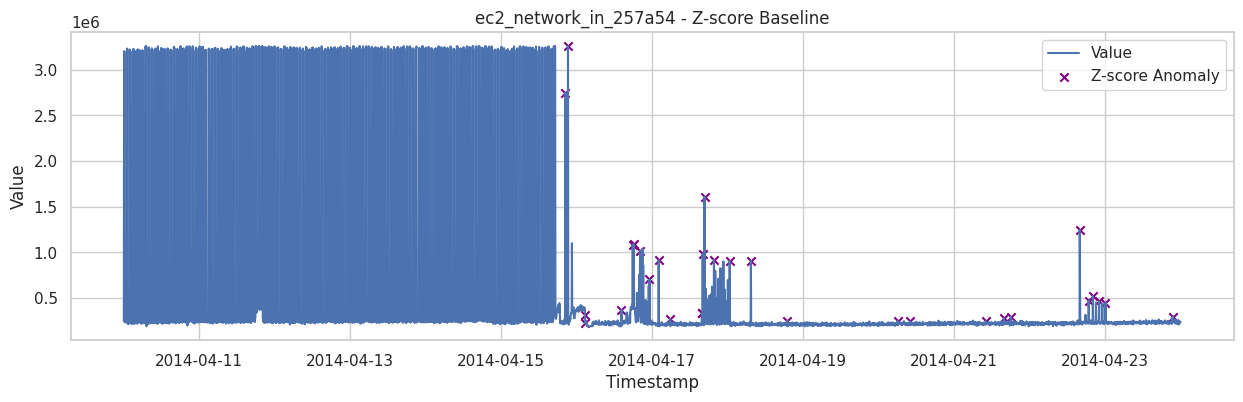

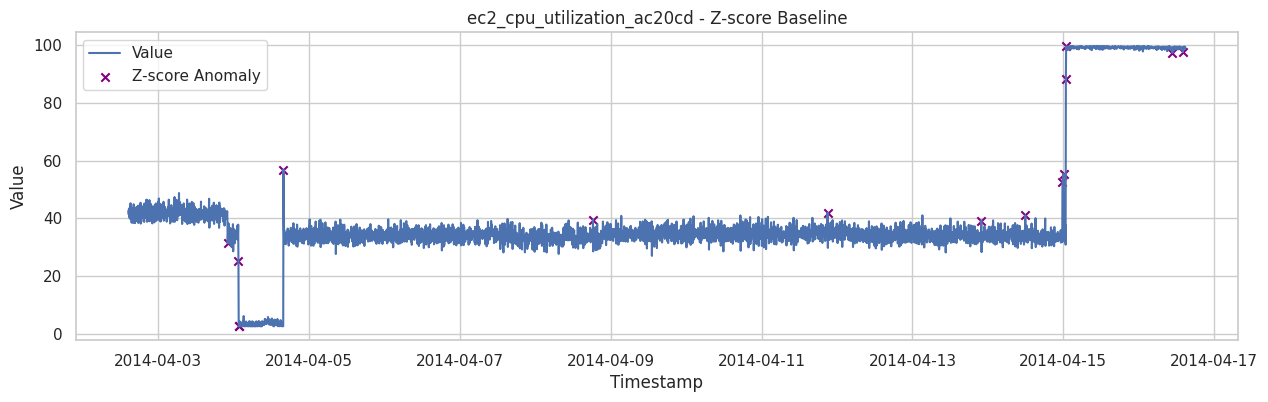

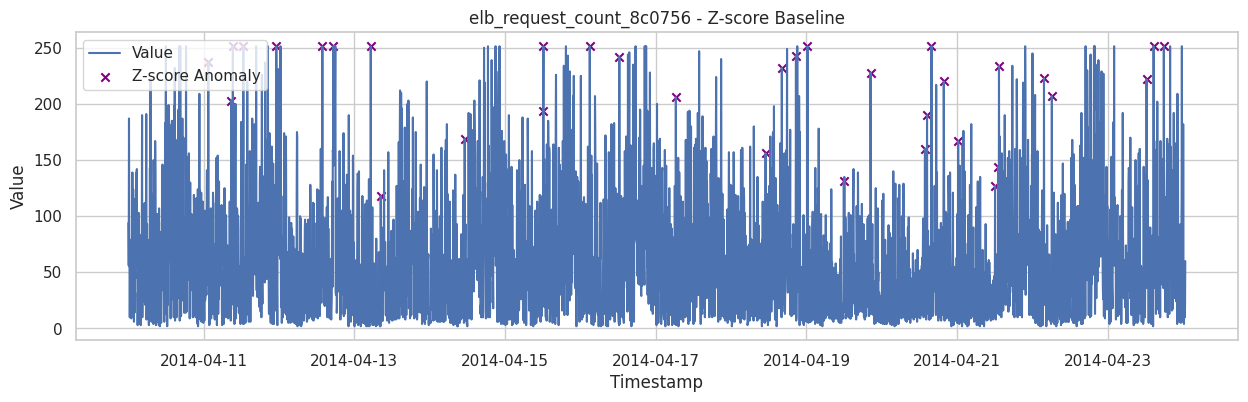

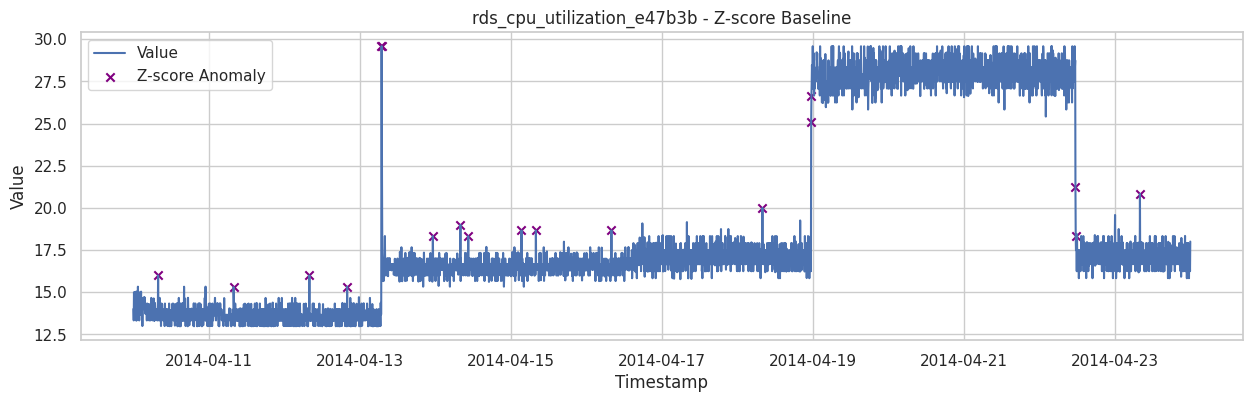

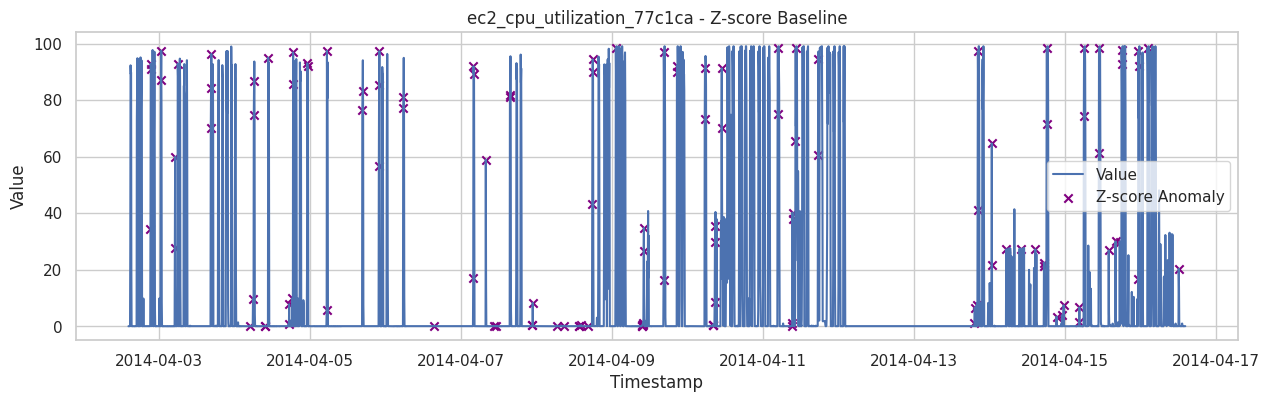

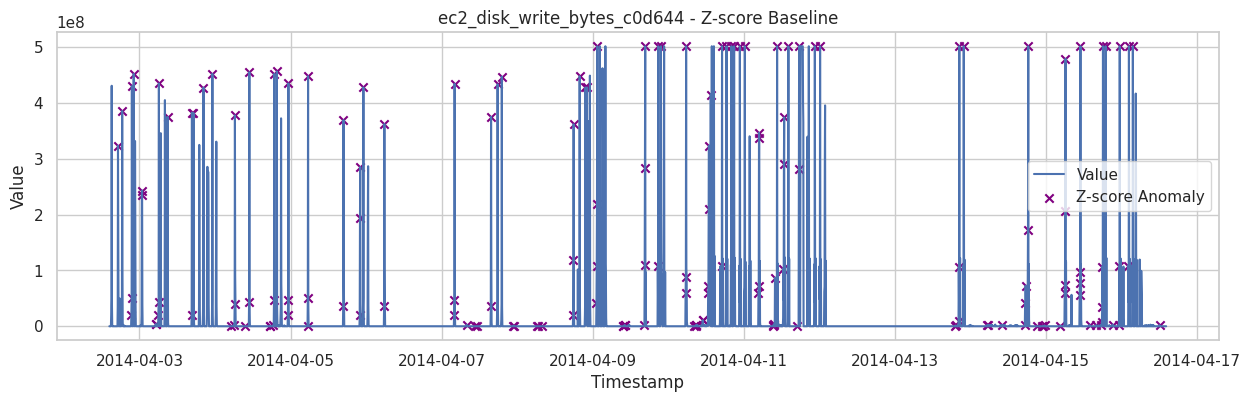

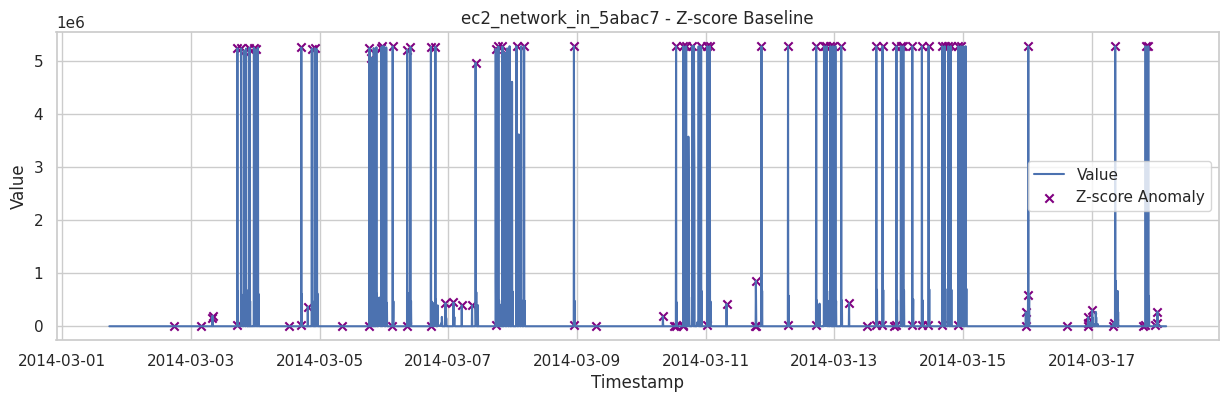

No ground truth anomalies found for evaluation.


In [9]:
# Baseline Anomaly Detection & Evaluation for AWS CloudWatch Time Series

import sys
import os
sys.path.append(os.path.abspath("../src"))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set up plotting
%matplotlib inline
sns.set(style='whitegrid')

# Load preprocessed data
data_dir = "../data/processed/aws_cloudwatch_data"
files = [f for f in os.listdir(data_dir) if f.endswith('_cleaned.csv')]
data = {f.replace('_cleaned.csv',''): pd.read_csv(os.path.join(data_dir, f), parse_dates=['timestamp']) for f in files}

print(f"Loaded metrics: {list(data.keys())}")

# Helper function: Evaluate anomalies
def eval_anomaly_detection(df, pred_col='pred_anomaly', label_col='label'):
    if label_col not in df or pred_col not in df:
        return {}
    tp = np.sum((df[label_col]==1) & (df[pred_col]==1))
    fp = np.sum((df[label_col]==0) & (df[pred_col]==1))
    fn = np.sum((df[label_col]==1) & (df[pred_col]==0))
    precision = tp/(tp+fp) if (tp+fp)>0 else 0
    recall = tp/(tp+fn) if (tp+fn)>0 else 0
    f1 = 2*precision*recall/(precision+recall) if (precision+recall)>0 else 0
    return {
        "TP": int(tp), "FP": int(fp), "FN": int(fn),
        "Precision": precision, "Recall": recall, "F1": f1
    }

# ---- Baseline 1: Moving Average + Std Threshold ----
window = 24  # e.g., 2 hours if 5-min intervals
threshold = 3  # 3 standard deviations

for name, df in data.items():
    df = df.copy()
    df = df.sort_values('timestamp')
    df['rolling_mean'] = df['value'].rolling(window, min_periods=1).mean()
    df['rolling_std'] = df['value'].rolling(window, min_periods=1).std().fillna(0)
    df['pred_anomaly'] = ((np.abs(df['value'] - df['rolling_mean']) > threshold * df['rolling_std'])).astype(int)
    data[name] = df

    # Plot with anomalies
    plt.figure(figsize=(15, 4))
    plt.plot(df['timestamp'], df['value'], label='Value')
    plt.plot(df['timestamp'], df['rolling_mean'], label='Moving Avg', alpha=0.7)
    plt.scatter(df.loc[df['pred_anomaly']==1, 'timestamp'],
                df.loc[df['pred_anomaly']==1, 'value'],
                color='orange', label='Pred. Anomaly', marker='x')
    if 'label' in df.columns and df['label'].sum()>0:
        plt.scatter(df.loc[df['label']==1, 'timestamp'],
                    df.loc[df['label']==1, 'value'],
                    color='red', label='True Anomaly', marker='o', facecolors='none')
    plt.title(f"{name} - Moving Avg Baseline")
    plt.xlabel("Timestamp")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

    # Print evaluation
    if 'label' in df.columns:
        metrics = eval_anomaly_detection(df)
        print(f"{name} Baseline Metrics:")
        for k, v in metrics.items():
            print(f"{k}: {v}")
        print("-----")

# ---- Baseline 2: Z-score Outlier Detection ----
window = 24
z_thresh = 3

for name, df in data.items():
    df = df.copy()
    df['zscore'] = (df['value'] - df['value'].rolling(window, min_periods=1).mean()) / (df['value'].rolling(window, min_periods=1).std().fillna(1))
    df['pred_anomaly_z'] = (np.abs(df['zscore']) > z_thresh).astype(int)
    data[name] = df

    # Plot with anomalies
    plt.figure(figsize=(15, 4))
    plt.plot(df['timestamp'], df['value'], label='Value')
    plt.scatter(df.loc[df['pred_anomaly_z']==1, 'timestamp'],
                df.loc[df['pred_anomaly_z']==1, 'value'],
                color='purple', label='Z-score Anomaly', marker='x')
    if 'label' in df.columns and df['label'].sum()>0:
        plt.scatter(df.loc[df['label']==1, 'timestamp'],
                    df.loc[df['label']==1, 'value'],
                    color='red', label='True Anomaly', marker='o', facecolors='none')
    plt.title(f"{name} - Z-score Baseline")
    plt.xlabel("Timestamp")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

    # Print evaluation
    if 'label' in df.columns:
        metrics = eval_anomaly_detection(df, pred_col='pred_anomaly_z')
        print(f"{name} Z-score Metrics:")
        for k, v in metrics.items():
            print(f"{k}: {v}")
        print("=====")

# ---- Summary Table ----
results = []
for name, df in data.items():
    if 'label' in df.columns:
        m1 = eval_anomaly_detection(df)
        m2 = eval_anomaly_detection(df, pred_col='pred_anomaly_z')
        results.append({
            "metric": name,
            "baseline_precision": m1.get("Precision", 0),
            "baseline_recall": m1.get("Recall", 0),
            "baseline_f1": m1.get("F1", 0),
            "zscore_precision": m2.get("Precision", 0),
            "zscore_recall": m2.get("Recall", 0),
            "zscore_f1": m2.get("F1", 0),
        })
if results:
    results_df = pd.DataFrame(results)
    print("\nSummary of Baseline Results:")
    print(results_df)
else:
    print("No ground truth anomalies found for evaluation.")

/tmp/ipykernel_28778/2396435616.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['pred_anomaly_iforest'] = test_preds


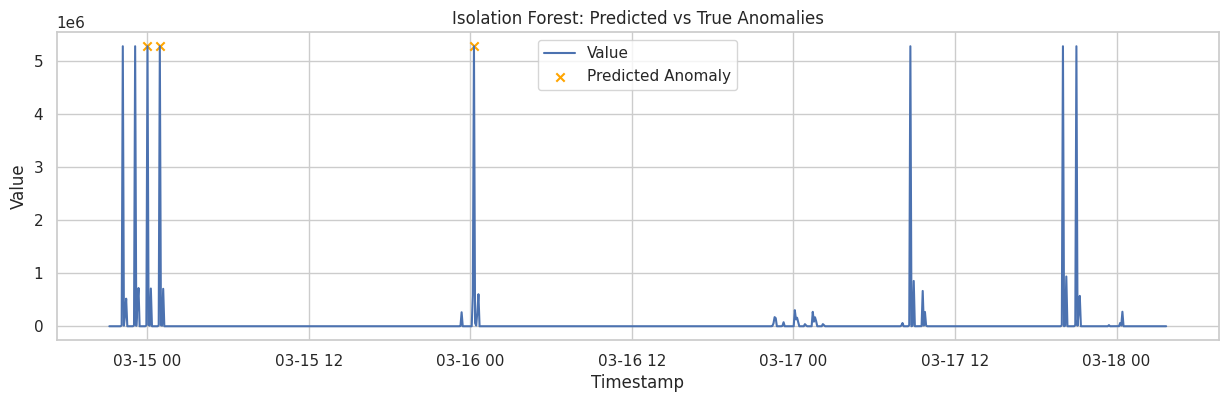

In [8]:
# Advanced ML Modeling for Time Series Anomaly Detection

import sys
import os
sys.path.append(os.path.abspath("../src"))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML imports
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Use the already loaded dataframe 'df'
# df is already available in the notebook

# ----- Feature Engineering -----
df = df.sort_values('timestamp')
df['rolling_mean'] = df['value'].rolling(24, min_periods=1).mean()
df['rolling_std'] = df['value'].rolling(24, min_periods=1).std().fillna(0)
df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek

# Use only numeric features for ML
features = ['value', 'rolling_mean', 'rolling_std', 'hour', 'dayofweek']
X = df[features].fillna(0)

# ----- Train/Test Split -----
test_frac = 0.2
n_test = int(len(df) * test_frac)
X_train, X_test = X[:-n_test], X[-n_test:]
df_train, df_test = df[:-n_test], df[-n_test:]

# ----- Scale Features -----
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ----- Isolation Forest -----
iso = IsolationForest(contamination=0.01, random_state=42)
iso.fit(X_train_scaled)
test_scores = iso.decision_function(X_test_scaled)
test_preds = iso.predict(X_test_scaled)
# Predict: -1 = anomaly, 1 = normal
test_preds = (test_preds == -1).astype(int)
df_test['pred_anomaly_iforest'] = test_preds

# ----- Evaluation -----
if 'label' in df_test.columns:
    y_true = df_test['label'].values
    y_pred = df_test['pred_anomaly_iforest'].values
    print("Isolation Forest on test set:")
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

# ----- Visualization -----
plt.figure(figsize=(15,4))
plt.plot(df_test['timestamp'], df_test['value'], label='Value')
plt.scatter(df_test.loc[df_test['pred_anomaly_iforest']==1, 'timestamp'],
            df_test.loc[df_test['pred_anomaly_iforest']==1, 'value'],
            color='orange', marker='x', label='Predicted Anomaly')
if 'label' in df_test.columns and df_test['label'].sum()>0:
    plt.scatter(df_test.loc[df_test['label']==1, 'timestamp'],
                df_test.loc[df_test['label']==1, 'value'],
                color='red', marker='o', facecolors='none', label='True Anomaly')
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.legend()
plt.title("Isolation Forest: Predicted vs True Anomalies")
plt.show()

# ----- (Optional) Try Other Models -----
# e.g., One-Class SVM, Autoencoder, etc.